# Points

Calculating the points in polygons.

In [1]:
# Libraries

%run utilities.py

import sqlite3

import geopandas as gpd
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap
from descartes import PolygonPatch
from shapely.geometry import Point, Polygon, MultiPolygon

%matplotlib inline

---

In [2]:
# establish the DB connection
conn = sqlite3.connect(tweet_db)

In [3]:
# gets lat/lons
pts_df = pd.read_sql_query("select longitude, latitude from Raw;", conn)
pts_df.head()

,longitude,latitude
0,103.782900,1.520593
1,110.415306,-7.688465
2,106.938970,-6.220550
3,101.760120,2.962812
4,103.090640,5.407075


In [9]:
# create a geometry column in our point dataset to contain shapely geometry for geopandas to use
pts_df['geometry'] = pts_df.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
pts_df['x'] = pts_df['geometry'].map(lambda p: p.x)
pts_df['y'] = pts_df['geometry'].map(lambda p: p.y)

pts_df.head()

,longitude,latitude,geometry,x,y
0,103.782900,1.520593,POINT (103.7829 1.5205933),103.782900,1.520593
1,110.415306,-7.688465,POINT (110.415306 -7.688464999999999),110.415306,-7.688465
2,106.938970,-6.220550,POINT (106.93897 -6.22055),106.938970,-6.220550
3,101.760120,2.962812,POINT (101.76012 2.9628115),101.760120,2.962812
4,103.090640,5.407075,POINT (103.09064 5.4070754),103.090640,5.407075


In [5]:
### Maps

# colors
land_color = '#DDDDDD'
water_color = '#D2F5FF'
coastline_color = '#333333'
border_color = '#999999'

# Dimensions
map_width_m = 5000 * 1000 #5000 km
map_height_m = 3500 * 1000 #3500 km

# Albers Conical Equal Area projection for USA
albers_usa = {
    'datum':'NAD83',
    'ellps':'GRS80',
    'proj':'aea', 
    'lat_1':33, 
    'lat_2':45, 
    'lon_0':-97, 
    'lat_0':39, 
    'x_0':map_width_m/2, 
    'y_0':map_height_m/2,
    'units':'m'
 }

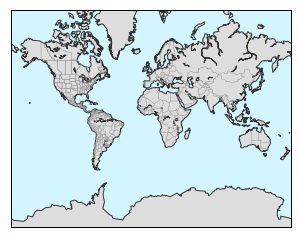

In [14]:
# matplotlib
m = Basemap(projection='merc',
            llcrnrlat=-80, urcrnrlat=80,
            llcrnrlon=-180, urcrnrlon=180,
            lat_ts=20, resolution='c')

m.drawcoastlines(color=coastline_color)
m.drawcountries(color=border_color)
m.fillcontinents(color=land_color, lake_color=water_color)
m.drawstates(color=border_color)
m.drawmapboundary(fill_color=water_color)

m.scatter(x=pts_df['x'], y=pts_df['y'], s=5, color='r', edgecolor='None', alpha=0.4, zorder=10)
plt.show()

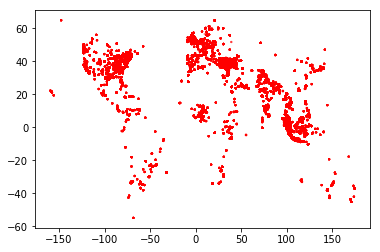

In [15]:
plt.scatter(x=pts_df['x'], y=pts_df['y'], s=5, color='r', edgecolor='None', alpha=0.3, zorder=10)